In [2]:
#Importamos las librerias necesarias.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv("meteorite-landings.csv") # Aqui realizamos la lectura de los datos del archivo csv

In [4]:
# Vemos las primeras cinco variables
data.head()

name   id nametype     recclass      mass  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong               GeoLocation  
0    6.08333     (50.775000, 6.083330)  
1   10.23333    (56.183330, 10.233330)  
2 -113.00000  (54.216670, -113.000000)  
3  -99.90000   (16.883330, -99.900000)  
4  -64.95000  (-33.166670, -64.950000)

## Explicación de los datos
- Name: El nombre del meteorito
- id: Identificador del meteorito
- Nametype: Variable categórica con 2 valores. "valid:" Considerado un meteorito típico. "relict:" Meteorito degradado por el clima de la tierra
- Recclass: Clase del meteorito, el cual se clasifica según múltiples carácteristicas físicas, químicas, etc.
- mass: Masa del meteorito en gramos
- fall: Describe si fue vista la caída del meteorito. "Fell:" El meteorito que cayó se observó. "Found:" La caída del meteorito no se observó
- year: El año en el que cayó el meteorito
- reclat: La latitud a la que cayó el meteorito
- reclong: La longitud a la que cayó el meteorito

In [5]:
data.describe() #Con esto observamos mediante una descripcion de los valores limites que en la masa o las coordenadas hay datos "0" los cuales
#no hacen sentido para nuestro analisis

id          mass          year        reclat       reclong
count  45716.000000  4.558500e+04  45428.000000  38401.000000  38401.000000
mean   26889.735104  1.327808e+04   1991.772189    -39.122580     61.074319
std    16860.683030  5.749889e+05     27.181247     46.378511     80.647298
min        1.000000  0.000000e+00    301.000000    -87.366670   -165.433330
25%    12688.750000  7.200000e+00   1987.000000    -76.714240      0.000000
50%    24261.500000  3.260000e+01   1998.000000    -71.500000     35.666670
75%    40656.750000  2.026000e+02   2003.000000      0.000000    157.166670
max    57458.000000  6.000000e+07   2501.000000     81.166670    354.473330

In [6]:
data.info() # De esta forma visualizamos la cantidad totales de datos no nulos en el data set, esto no implica que sean todos utilizables.
# Por lo tanto debemos seguir con un tratamiento de estos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


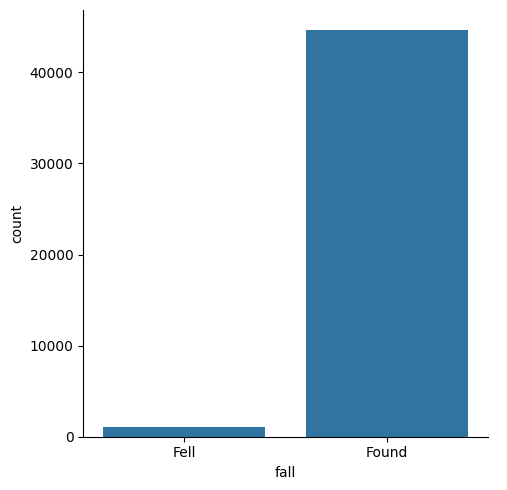

In [7]:
sns.catplot(data=data, x='fall',kind='count') # Queremos contar las entradas en cada categoría
plt.show()

Se nota claramente un fuerte desbalance de clase en la variable "Fall", esto lo tendremos en cuenta despues para trabajar más en profundidad.

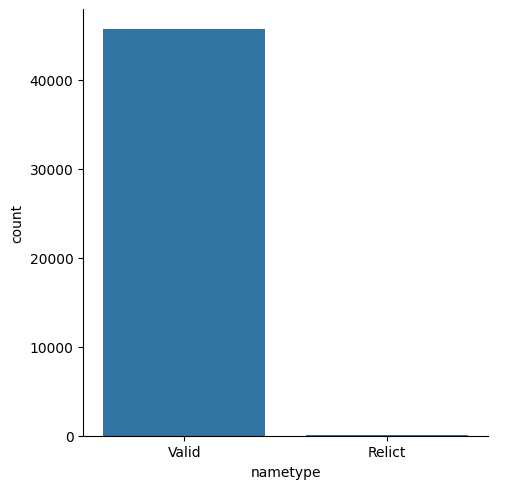

In [8]:
sns.catplot(data=data, x='nametype',kind='count') # Queremos contar las entradas en cada categoría
plt.show()

Igualmente que para la variable "Fall", "Name_type" presenta una diferencia de proporciones muy notoria. Esto nos entrega un analisis bastante interesante cuando hagamos la visualización de los datos y veamos que esto representa un "sesgo de ubicación"

Text(0.5, 0, 'mass')

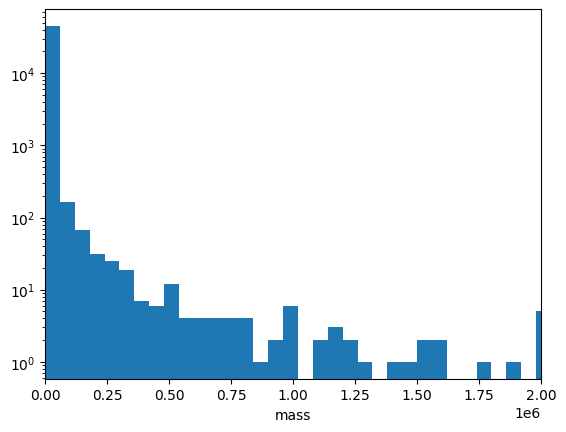

In [9]:
# Queremos ver la distribución de la masa.
plt.hist(data["mass"], bins=1000) #
#plt.xscale("log")
plt.yscale("log")
plt.xlim(0,2e6)
plt.xlabel('mass')

Dada la gran diferencia entre los valores de baja masa (gramos) a altas masas (toneladas) decidimos observar el eje y de forma logaritmica.

In [10]:
# Creamos un for loop para detectar todos los valores nulos "nan" en la variable "reclat"
where = []
cont = 0
for i in data["reclat"]:
    if np.isnan(i) == False:
        where.append(cont)
    cont += 1

In [11]:
data_complete = data.iloc[where]

In [12]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38401 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38401 non-null  object 
 1   id           38401 non-null  int64  
 2   nametype     38401 non-null  object 
 3   recclass     38401 non-null  object 
 4   mass         38282 non-null  float64
 5   fall         38401 non-null  object 
 6   year         38226 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


(1700.0, 2014.0)

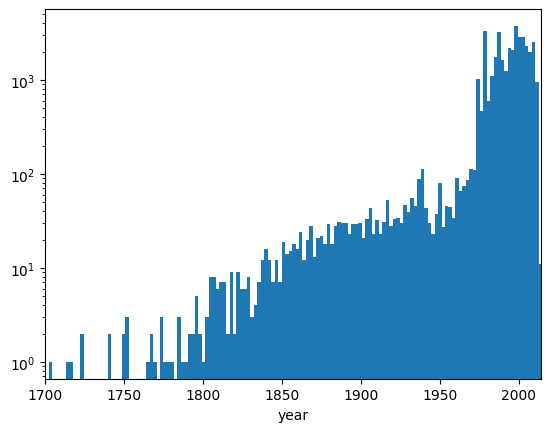

In [13]:
# Hay una pequeña cantidad de datos nulos en la variables años y masa.
# Vamos a revisarlos.
plt.hist(data_complete["year"], bins=1000)
plt.yscale("log")
plt.xlabel("year")
plt.xlim(1700,2014)

(0.0, 2100000.0)

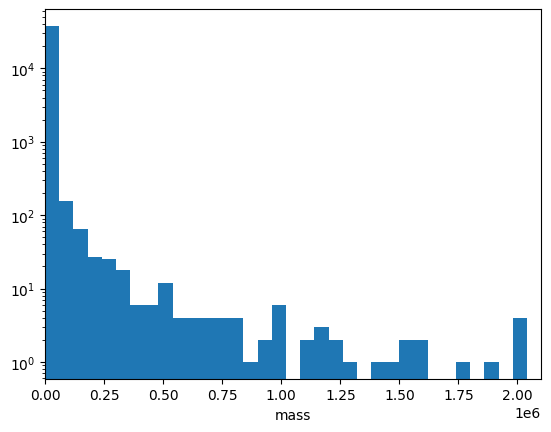

In [14]:
#De igual forma quisimos visualizar el histograma de la distribución de masas en nuestro dataset, donde dado el desbalance entre las masas de los objetos (de gramos a toneladas), tomando el
#logaritmo al eje y para facilitar el análisis.

plt.hist(data_complete["mass"], bins=1000)
plt.yscale("log")
plt.xlabel("mass")
plt.xlim(0,2.1e6)

In [15]:
# De igual forma como trabajamos los datos nulos para la variable de latitud, decidimos hacer un for loop para contabilizar y eliminar los valores nulos de masa.
where_2 = []
cont = 0
for i in data_complete["mass"]:
    if np.isnan(i) == False:
        where_2.append(cont)
    cont += 1

In [16]:
data_complete_2 = data_complete.iloc[where_2] # Aplicamos esta corrección a nuestro dataset.

In [17]:
data_complete_2.info() # Confirmamos que se aplico

<class 'pandas.core.frame.DataFrame'>
Index: 38282 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38282 non-null  object 
 1   id           38282 non-null  int64  
 2   nametype     38282 non-null  object 
 3   recclass     38282 non-null  object 
 4   mass         38282 non-null  float64
 5   fall         38282 non-null  object 
 6   year         38116 non-null  float64
 7   reclat       38282 non-null  float64
 8   reclong      38282 non-null  float64
 9   GeoLocation  38282 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


In [18]:
#Por tercera vez, hacemos el mismo tratamiento para la variable year, donde tambien se observaron datos absurdos de años de registros
#efectuando el mismo for loop:
where_3 = []
cont = 0
for i in data_complete_2["year"]:
    if np.isnan(i) == False:
        where_3.append(cont)
    cont += 1

In [19]:
data_final = data_complete_2.iloc[where_3] # aplicando la corrección.

In [20]:
data_final.info() # checkeando si se aplico.

<class 'pandas.core.frame.DataFrame'>
Index: 38116 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38116 non-null  object 
 1   id           38116 non-null  int64  
 2   nametype     38116 non-null  object 
 3   recclass     38116 non-null  object 
 4   mass         38116 non-null  float64
 5   fall         38116 non-null  object 
 6   year         38116 non-null  float64
 7   reclat       38116 non-null  float64
 8   reclong      38116 non-null  float64
 9   GeoLocation  38116 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


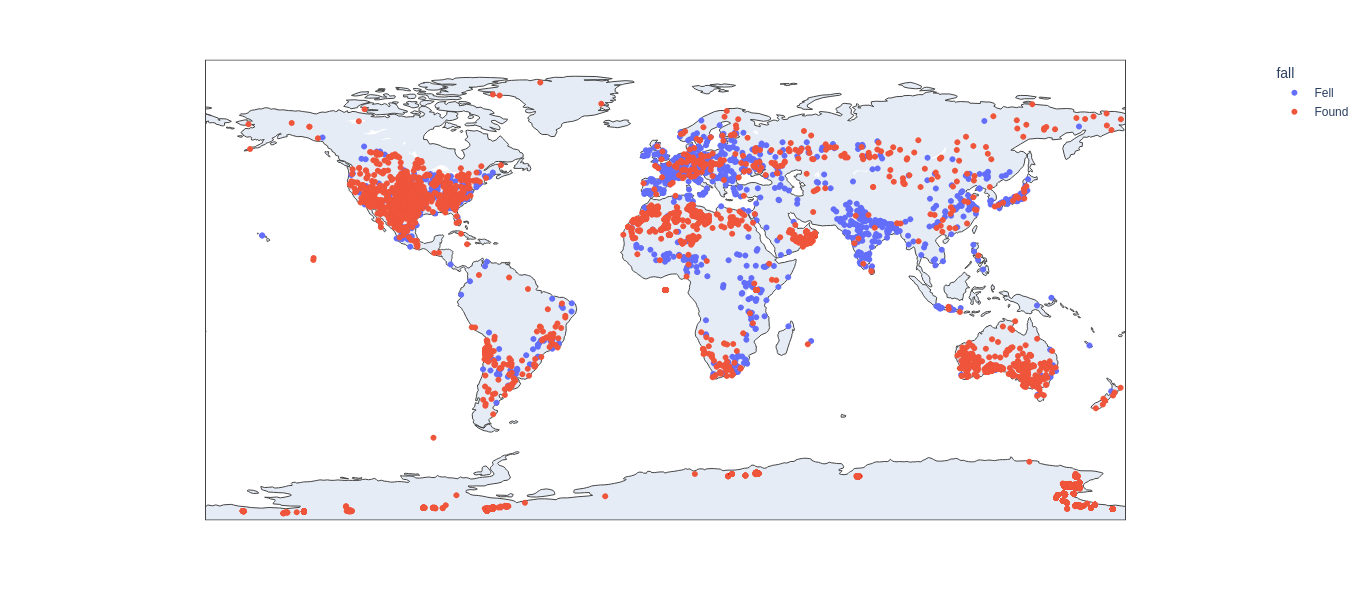

In [21]:
# Para visualizar los datos, usaremos la información entregada por las variables lat y long para "plotear" los puntos de los registros en un mapa de la tierra.
#Donde en este caso se muestra la variable "fall" con sus clases "fell" y "found" mostradas por separado
px.scatter_geo(data_frame = data_final, lat = 'reclat', lon = 'reclong', color = 'fall',width=1000, height=600)

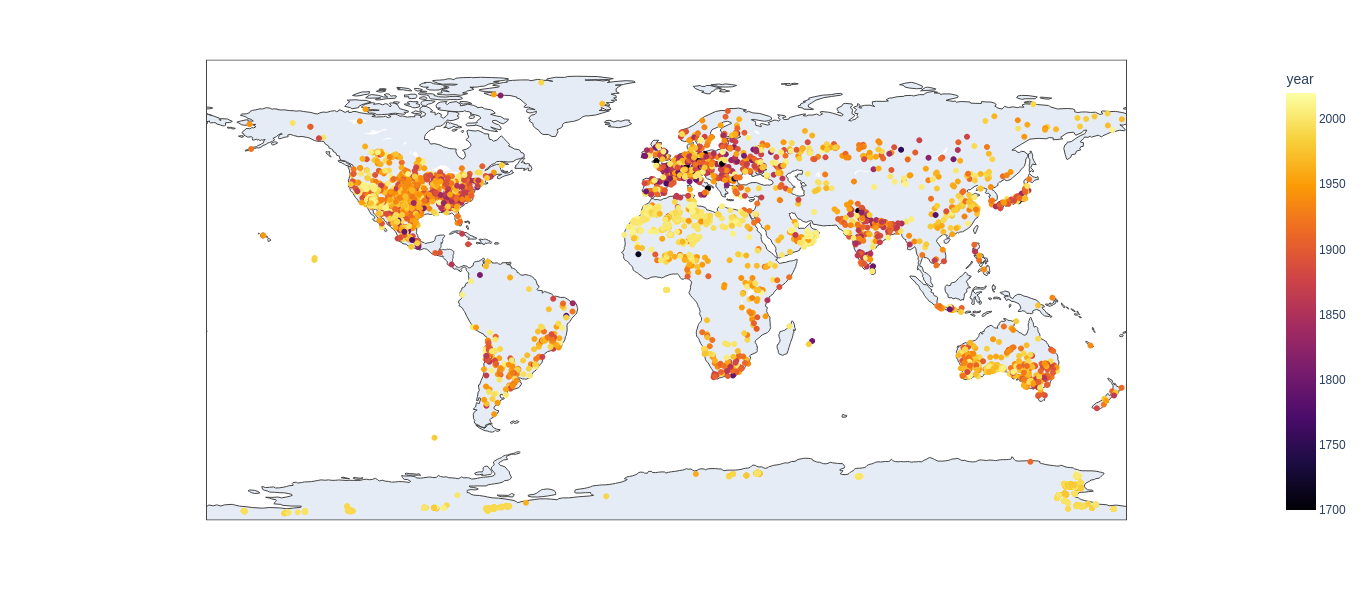

In [22]:
# De igual forma se decidio usar el mismo estilo de visualización para ver los años de cada registro, donde se notan leves patrones en como estan distribuidos estos puntos. Notamos que los registros
#más "nuevos" estan en zona saharianas y en sectores de la costa oeste de Estados Unidos. Mirando al otro extremo, los registros mas "viejo" provienen principalmente de Europa y Asia
px.scatter_geo(data_frame = data_final, lat = 'reclat', lon = 'reclong', color = 'year',width=1000, height=600, range_color= [1700, 2020], color_continuous_scale='inferno')

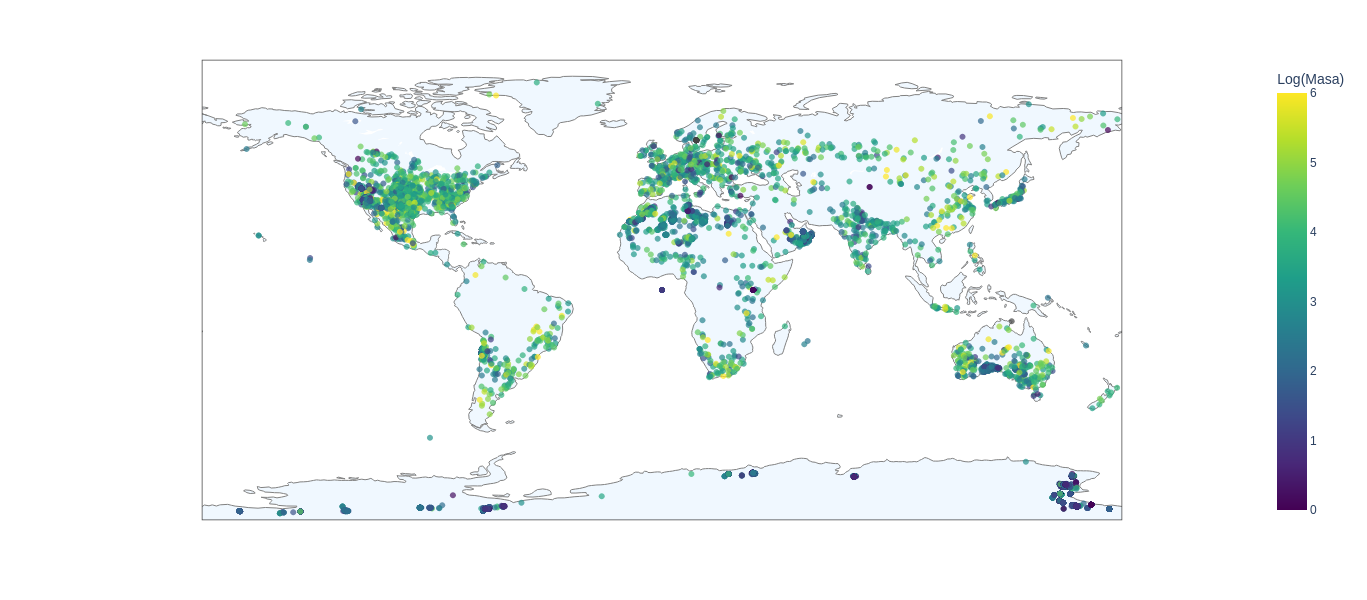

In [23]:
# 1. Asegurarnos de tener la columna logarítmica
if 'log_mass' not in data_complete_2.columns:
    data_complete_2 = data_complete_2.copy()
    data_complete_2['log_mass'] = np.log10(data_complete_2['mass'].replace(0, np.nan))

# 2. Crear el gráfico con el rango ajustado según el histograma
fig = px.scatter_geo(
    data_frame=data_complete_2,
    lat='reclat',
    lon='reclong',

    # Variable de color
    color='log_mass',

    width=1000,
    height=600,

    # Escala de color de alto contraste
    color_continuous_scale='Viridis',

    # AJUSTE CLAVE: Limitamos el rango de color al área de mayor densidad del histograma
    # Esto hace que los valores dentro de este rango usen todo el espectro de color
    range_color=[0, 6],

    opacity=0.7,

    # Proyección rectangular
    projection="equirectangular",

    # Datos al pasar el cursor
    hover_data={'mass': True, 'log_mass': ':.2f', 'reclat': False, 'reclong': False}
)

# Estética del mapa
fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Grey",
    showland=True,
    landcolor="AliceBlue",
    showocean=True,
    oceancolor="White"
)

fig.update_layout(coloraxis_colorbar=dict(title="Log(Masa)"))

fig.show()

Como análisis más general que se puede hacer con este tipo de visualización es el de porque notamos sectores esencialmente "vacios" de registros. Según nosotros se le pueden atribuir 2 razones a esto. La primera es la densidad poblacional y como esta tiene directa relación con los registros. Mientras más gente hay en un dado sector (o mientras mayor sea la gente activamente buscando) es más problable tomarse con meteoritos o verlos caer. Pero la razón más logica segun nosotros es la climatologica, donde si notamos, claramente las zonas de climas tropicales, boscosos y escencialmente humedos presentas una tasa de registros mucho menor o simplemente no hay. Esto se explica facilmente con el hecho de que esos ambientes climaticos pueden facilitar la erosión de los meteoritos, basicamente "escondiendolos" y reincorporandolos al medioambiente. Esto tiene mucho sentido si tomamos en consideración el histograma de "Name_type" donde se analizan las frecuencias entre "valid" y "relic", el cual este ultimo indicaba meteoritos que fueron afectados por daños de tipo meteorológico.

Finalmente, dado nuestro motivo original de proyecto (que era encontrar una relación entre las variables "fall" y "name_type") decidimos volver a "Plotear" los histogramas de estas con los datos ya limpios

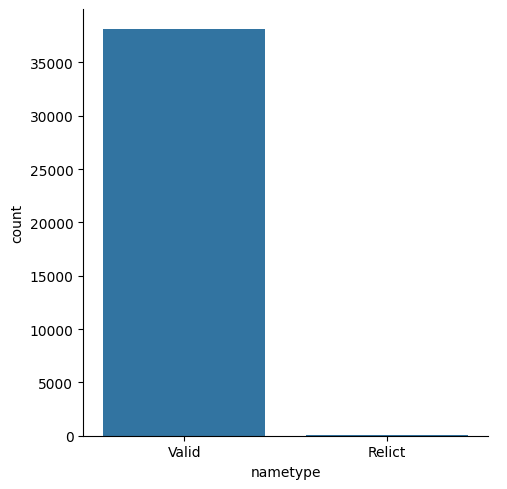

In [24]:
sns.catplot(data=data_final, x='nametype',kind='count')# queremos contar las entradas en cada categoría
plt.show()

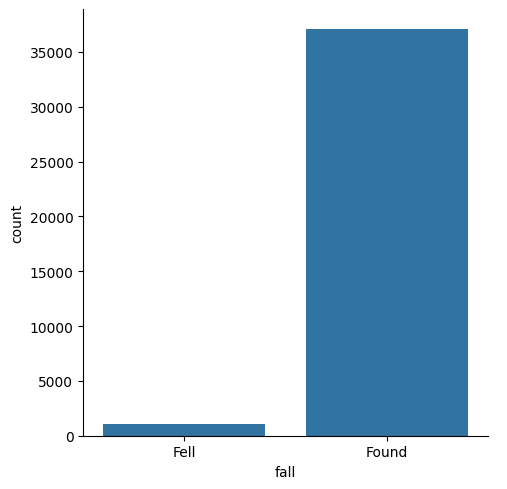

In [25]:
sns.catplot(data=data_final, x='fall',kind='count') #Queremos contar las entradas en cada categoría
plt.show()

Finalmente, dado el severo desbalance de clases dentro de estas variables, se decidido optar por otro enfoque. La cuál es analizar la variable "recclass", la usaremos para predecir el tipo de meteorito (con sus debidas propiedades físicas) usando modelos de machine learning. Esto vendria con un proposito de poder, en base a los registros de objetos aca en la tierra, predecir la frecuencia de caida y propiedades de meteoritos que podrian impactar en un futuro

In [26]:
# Vemos los tipos de meteoritos
lista = data_final['recclass']
lista

0                          L5
1                          H6
2                         EH4
3                 Acapulcoite
4                          L6
                 ...         
45711                 Eucrite
45712    Pallasite, ungrouped
45713                      H4
45714                      L6
45715                    L3.7
Name: recclass, Length: 38116, dtype: object

In [28]:
# Los que más se repiten
data_final['recclass'].value_counts().head(50)

recclass
L6                       7519
H5                       6243
H6                       3898
H4                       3880
L5                       3264
LL5                      2199
LL6                      1660
L4                        939
H4/5                      395
CM2                       330
H3                        313
CO3                       308
Iron, IIIAB               270
L3                        268
LL                        223
Ureilite                  214
E3                        205
LL4                       198
CV3                       184
Howardite                 179
Diogenite                 178
Eucrite-pmict             169
H5/6                      166
CR2                       116
Eucrite                   115
Iron, IIAB                111
Mesosiderite              107
H~5                       106
Iron, ungrouped           105
LL3                        88
L~6                        85
L3.5                       84
Eucrite-mmict              84
I

In [29]:
# Utilizando como referencia https://en.wikipedia.org/wiki/Meteorite_classification para poder clasificar los meteoritos.
# Separamos por clases con la siguiente función
def group_id(rec):
    r = str(rec).upper()

    if r.startswith(("H", "L", "LL")):
        return 0

    if r.startswith("C"):
        return 1

    if "IRON" in r:
        return 2

    ach = ["HOW", "EUC", "DIO", "UR", "ANGR", "AUBR", "ACAP", "LODR", 'WIN', 'BRAC', 'SHER', 'NAK', 'CHASS']
    if any(a in r for a in ach):
        return 3

    if "PALL" in r or "MESO" in r:
        return 4

    else:
        return 5

# Lo incluimos dentro de los datos
data_final["group_id"] = data_final["recclass"].apply(group_id)
data_final

name     id nametype              recclass      mass   fall  \
0          Aachen      1    Valid                    L5      21.0   Fell   
1          Aarhus      2    Valid                    H6     720.0   Fell   
2            Abee      6    Valid                   EH4  107000.0   Fell   
3        Acapulco     10    Valid           Acapulcoite    1914.0   Fell   
4         Achiras    370    Valid                    L6     780.0   Fell   
...           ...    ...      ...                   ...       ...    ...   
45711  Zillah 002  31356    Valid               Eucrite     172.0  Found   
45712      Zinder  30409    Valid  Pallasite, ungrouped      46.0  Found   
45713        Zlin  30410    Valid                    H4       3.3  Found   
45714   Zubkovsky  31357    Valid                    L6    2167.0  Found   
45715  Zulu Queen  30414    Valid                  L3.7     200.0  Found   

         year    reclat    reclong               GeoLocation  group_id  
0      1880.0  50.77500    6.08333     (50.775000, 6.083330)         0  
1      1951.0  56.18333   10.23333    (56.183330, 10.233330)         0  
2      1952.0  54.21667 -113.00000  (54.216670, -113.000000)         5  
3      1976.0  16.88333  -99.90000   (16.883330, -99.900000)         3  
4      1902.0 -33.16667  -64.95000  (-33.166670, -64.950000)         0  
...       ...       ...        ...                       ...       ...  
45711  1990.0  29.03700   17.01850    (29.037000, 17.018500)         3  
45712  1999.0  13.78333    8.96667     (13.783330, 8.966670)         4  
45713  1939.0  49.25000   17.66667    (49.250000, 17.666670)         0  
45714  2003.0  49.78917   41.50460    (49.789170, 41.504600)         0  
45715  1976.0  33.98333 -115.68333  (33.983330, -115.683330)         0  

[38116 rows x 11 columns]

In [30]:
# Sacamos todas las filas que puedan generar dataleak o que no sirven.
data_final.drop('name', axis = 1, inplace = True)
data_final.drop('id', axis = 1, inplace = True)
data_final.drop('recclass', axis = 1, inplace = True)
data_final.drop('GeoLocation', axis = 1, inplace = True)
data_final.drop('fall', axis = 1, inplace = True)


In [31]:
data_final

nametype      mass    year    reclat    reclong  group_id
0        Valid      21.0  1880.0  50.77500    6.08333         0
1        Valid     720.0  1951.0  56.18333   10.23333         0
2        Valid  107000.0  1952.0  54.21667 -113.00000         5
3        Valid    1914.0  1976.0  16.88333  -99.90000         3
4        Valid     780.0  1902.0 -33.16667  -64.95000         0
...        ...       ...     ...       ...        ...       ...
45711    Valid     172.0  1990.0  29.03700   17.01850         3
45712    Valid      46.0  1999.0  13.78333    8.96667         4
45713    Valid       3.3  1939.0  49.25000   17.66667         0
45714    Valid    2167.0  2003.0  49.78917   41.50460         0
45715    Valid     200.0  1976.0  33.98333 -115.68333         0

[38116 rows x 6 columns]

In [32]:
# Asignamos un valor numerico a la variable para poder utilizarla.
def nametype(rec):
    if rec == "Valid":
        return 1

    if rec == 'Relict':
        return 0

data_final["name_type"] = data_final["nametype"].apply(nametype)

In [33]:
# Asiganos como labels a las variables ha utilizar y quitamos de los datos
labels = data_final['group_id']
data_final.drop('group_id', axis = 1, inplace = True)
data_final.drop('nametype', axis = 1, inplace = True)

In [34]:
data_final

mass    year    reclat    reclong  name_type
0          21.0  1880.0  50.77500    6.08333          1
1         720.0  1951.0  56.18333   10.23333          1
2      107000.0  1952.0  54.21667 -113.00000          1
3        1914.0  1976.0  16.88333  -99.90000          1
4         780.0  1902.0 -33.16667  -64.95000          1
...         ...     ...       ...        ...        ...
45711     172.0  1990.0  29.03700   17.01850          1
45712      46.0  1999.0  13.78333    8.96667          1
45713       3.3  1939.0  49.25000   17.66667          1
45714    2167.0  2003.0  49.78917   41.50460          1
45715     200.0  1976.0  33.98333 -115.68333          1

[38116 rows x 5 columns]

In [35]:
# Lo transformamos en data frame
labels = pd.DataFrame(labels)

In [36]:
# Para hacer los graficos de curvas de aprendizaje
# vamos a hacer las learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'recall_macro'):

    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

In [37]:
# Ahora utilizamos StratifiedKFold.
cv1 = StratifiedKFold(shuffle=True, n_splits=5, random_state=2)

# Hacemos esto por si viene como DataFrame col=1, en 1D y/o asegurase de que sean valores enteros.
y = labels.squeeze()
y = y.to_numpy().ravel()
y = y.astype(int)

In [38]:
# Ahora haciendo la validación cruzada.https://en.wikipedia.org/wiki/Meteorite_classification
scores1 = cross_validate(DecisionTreeClassifier(), data_final, y, cv = cv1, scoring = 'recall_macro', return_train_score=True)
scores1

{'fit_time': array([0.24183202, 0.14469337, 0.14474082, 0.15036273, 0.15202522]),
 'score_time': array([0.00373125, 0.0036335 , 0.00347495, 0.00347638, 0.00349593]),
 'test_score': array([0.32747161, 0.33689595, 0.3341663 , 0.33279861, 0.31352476]),
 'train_score': array([0.90929287, 0.90372887, 0.91071779, 0.90601666, 0.90467446])}

In [39]:
# Cortando para solo el 15 porciento de los datos
datos_5 = int(len(data_final) * 0.15)
x_chico = data_final[:datos_5]
y_chico = y[:datos_5]

# Hacemos el piped_model
piped_model = make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=0))

In [40]:
# Damos un rango de valores para ajustar los hiperparametros
parameters = {"decisiontreeclassifier__max_depth": [None, 3, 5, 8, 12, 20, 30],"decisiontreeclassifier__min_samples_split": [2, 5, 10, 20, 50],
"decisiontreeclassifier__min_samples_leaf": [1, 2, 5, 10, 20],
"decisiontreeclassifier__criterion": ["gini", "entropy"],
"decisiontreeclassifier__class_weight": [None, "balanced"]}

# Hacemos una separación de los datos de entrenamiento y prueba.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Hacemos que busque los hiperpametros y nos diga cual es el mejor.
model = GridSearchCV(piped_model, parameters, cv=cv, verbose=2, n_jobs=4, scoring='recall_macro',return_train_score=True)
model.fit(x_chico, y_chico)
print('Best params, best score:',"{:.4f}".format(model.best_score_),model.best_params_)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=5; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=5; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_spli

In [41]:
# Con los hiperparametros optimizados, hacemos un nuevo árbol de decisión.
DT_model = DecisionTreeClassifier(class_weight= 'balanced', criterion= 'gini', max_depth= 12, min_samples_leaf= 1, min_samples_split= 50)
cv2 = StratifiedKFold(n_splits= 5, shuffle=True, random_state=2)

# Hacemos la validación cruzada, mostrando los puntajes para el entrenamiento y prueba.
l_benchmark_lim = cross_validate(DT_model, data_final, y, cv = cv2, scoring = 'recall_macro', return_train_score=True)
l_benchmark_lim

{'fit_time': array([0.10001373, 0.09017086, 0.08704638, 0.09259701, 0.10233688]),
 'score_time': array([0.00311542, 0.00302482, 0.00297642, 0.00300241, 0.00321317]),
 'test_score': array([0.45266586, 0.47645851, 0.46852104, 0.43098893, 0.46585627]),
 'train_score': array([0.65323982, 0.63158295, 0.62138426, 0.63943439, 0.656985  ])}

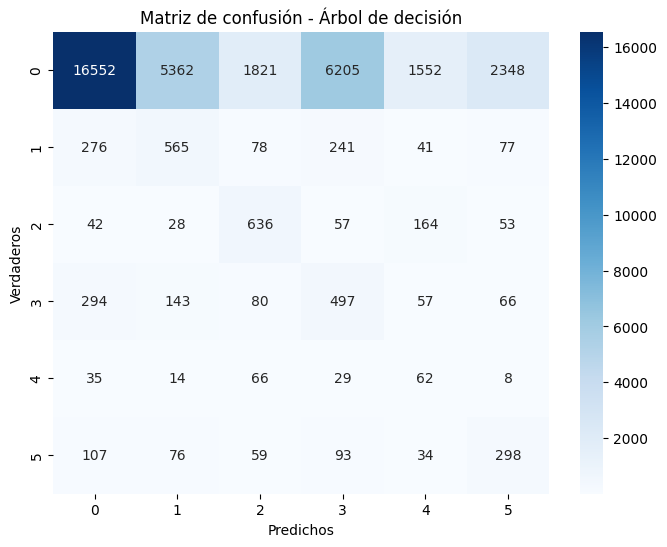

In [42]:
# Hacemos la predición del modelo.
ypred_DT = cross_val_predict(DT_model, data_final, y, cv = cv2)

# Ploteamos la matriz de confusión.
cm = confusion_matrix(y, ypred_DT)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predichos")
plt.ylabel("Verdaderos")
plt.title("Matriz de confusión - Árbol de decisión")
plt.show()

[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=30, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=20; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=30, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=20; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=30, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=20; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=30, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=20; total time=   0.0s
[CV] END decisio

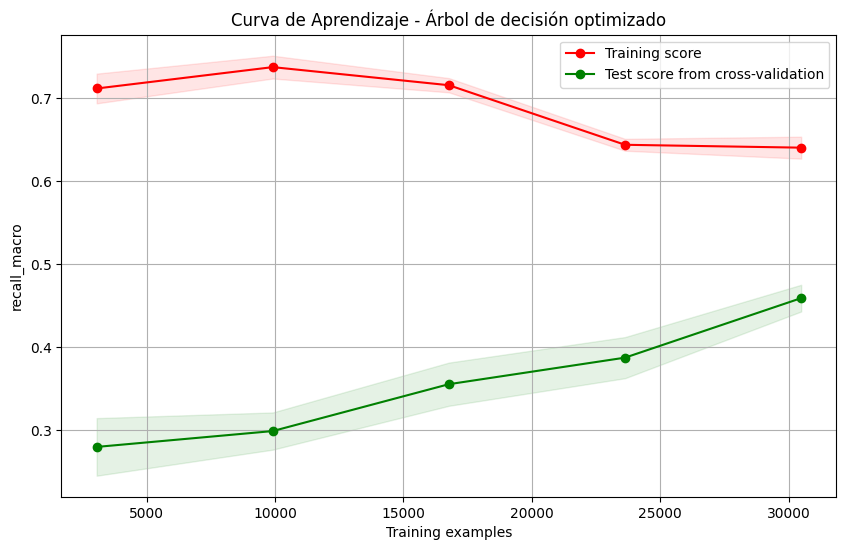

In [43]:
# Ploteamos la curva de aprendizaje de árbol de decisión.
plot_learning_curve(DT_model, 'Curva de Aprendizaje - Árbol de decisión optimizado', data_final, y,  cv = cv2, scoring = 'recall_macro');
plt.show()

Para el árbol de decisión, comencemos analizando la matriz de confusión. Se observa que el modelo tiende a predecir mayoritariamente la clase 0, confundiendo otras clases con este valor. Esto ya sugiere que el desbalanceo de las clases está afectando de manera significativa el rendimiento del modelo.

A primera vista podría parecer que el árbol de decisión es un mal modelo. Sin embargo, al revisar la curva de aprendizaje, se aprecia que, aunque existe tanto alto sesgo (bias) como alta varianza entre los conjuntos de entrenamiento y prueba, ambas comienzan a disminuir a medida que aumenta la cantidad de datos. Esto indica que el modelo sí está aprendiendo.

Si se contara con un conjunto de datos más amplio y mejor balanceado, el árbol de decisión tendría el potencial de desempeñarse mucho mejor y lograr predicciones más fiables sobre las clases de interés.

In [44]:
# Ahora pra svm
# Inicializamos el modelo SVM.
SVM_model = SVC(kernel='rbf', C = 1)

# Hacemos un kfold para el modelo.
cv3 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# Junto con la validación cruzada
l_benchmark_lim = cross_validate(SVM_model, data_final, y, cv = cv3, scoring = 'recall_macro', return_train_score=True)
l_benchmark_lim

{'fit_time': array([5.64063287, 5.09229898, 4.8217833 , 4.75757718, 5.15702391]),
 'score_time': array([1.7557025 , 1.60371137, 1.71202159, 1.62366033, 1.67294717]),
 'test_score': array([0.17932327, 0.18359959, 0.17587265, 0.17767184, 0.18364884]),
 'train_score': array([0.18319201, 0.17997333, 0.18182296, 0.18179833, 0.17925347])}

In [45]:
# Cortando para solo el 15 porciento de los datos.
datos_5 = int(len(data_final) * 0.15)
x_chico = data_final[:datos_5]
y_chico = y[:datos_5]

In [ ]:
# Ajustando los hiperparametros.
piped_model_svc = make_pipeline(StandardScaler(), SVC())

# Inicializando los parametros iniciales.
parameters_svc = {'svc__kernel':['rbf'],'svc__C':[0.1, 1, 10, 100], 'svc__gamma':["scale", 0.01, 0.1, 0.5, 1], 'svc__class_weight':[None, "balanced",{1:1},{1:3},{1:5}]}

# Hacemos que busque el mejor valor.
model = GridSearchCV(piped_model_svc, parameters_svc, cv = StratifiedKFold(n_splits=5, shuffle=True), verbose = 2, n_jobs = 4, scoring = 'recall_macro', return_train_score=True)
model.fit(x_chico, y_chico)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=scale, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=0.01, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=0.5, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf; total time=   2.0s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf; total time=   2.0s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.01, svc__kernel=rbf; total time=   2.3s
[CV] END svc__C=0.1, svc__class_weight=balance

In [46]:
# Ahora inicializamos nuevamente SVC junto con las parametros optimizados.
SVM_model_best = SVC(kernel='rbf', C = 100, gamma= 0.5, class_weight = 'balanced')

# Hacemos nuevamente un StratifiedKFold.
cv4 = StratifiedKFold(n_splits= 3, shuffle=True, random_state=2)

# Hacemos la validación cruzada.
l_benchmark_lim = cross_validate(SVM_model_best, data_final, y, cv = cv4, scoring = 'recall_macro', return_train_score=True)
l_benchmark_lim

{'fit_time': array([122.1830709 , 113.96480584, 116.86022043]),
 'score_time': array([10.19293141, 10.08689427, 10.22960734]),
 'test_score': array([0.25558772, 0.26896243, 0.25534892]),
 'train_score': array([0.95298443, 0.95120081, 0.9503689 ])}

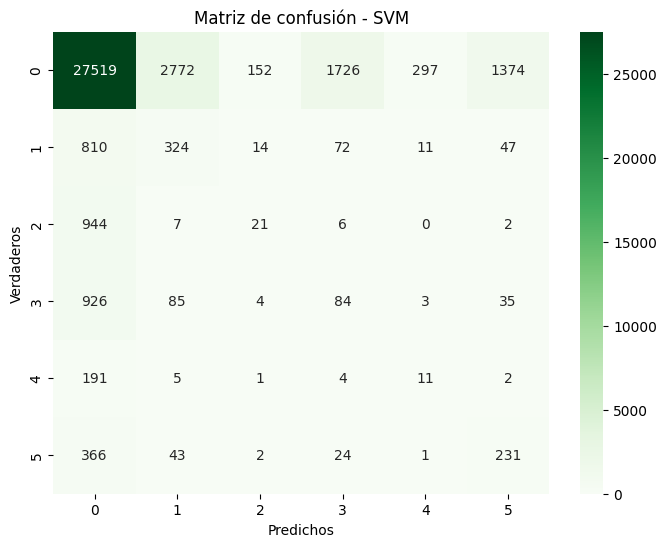

In [47]:
# Hacemos la predicción.
ypred_SVM = cross_val_predict(SVM_model_best, data_final, y, cv = cv4)

# Matriz de confusión.
cm = confusion_matrix(y, ypred_SVM)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predichos")
plt.ylabel("Verdaderos")
plt.title("Matriz de confusión - SVM")
plt.show()

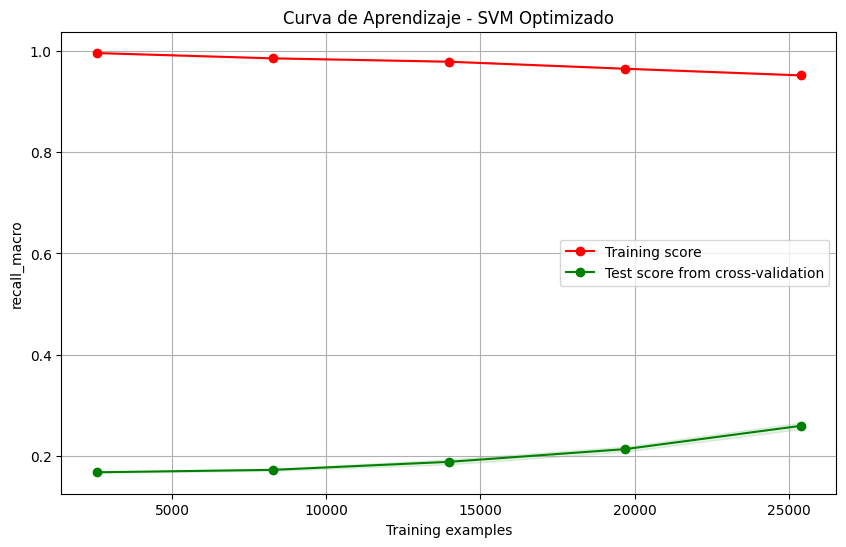

In [48]:
# Curva de crecimiento del SVM optimizado.
plot_learning_curve(SVM_model_best, 'Curva de Aprendizaje - SVM Optimizado', data_final, y,  cv = cv4, scoring = 'recall_macro');
plt.show()

En el caso del SVM, el modelo presentó un rendimiento muy bajo. En la matriz de confusión se observa que clasificó todas las instancias como clase 0, lo que refleja que fue fuertemente afectado por el desbalance de clases, impidiéndole distinguir adecuadamente entre las distintas categorías y, por tanto, realizar predicciones correctas.

Esta conclusión se refuerza al analizar la curva de aprendizaje, donde se aprecia una alta varianza y alto bias. Ambos valores comienzan a disminuir recién alrededor de los 15 000 datos, lo que indica que el modelo es capaz de aprender con suficiente información. Sin embargo, su desempeño sigue siendo bajo incluso con muchos datos, lo que sugiere que el algoritmo tiende a estancarse rápidamente.

Además, es importante considerar que el SVM no es un modelo intrínsecamente multiclase; requiere estrategias adicionales para abordar este tipo de problemas. Este aspecto no se tomó en cuenta durante el desarrollo, lo cual también explica su pobre rendimiento. Por ello, los resultados obtenidos con SVM no deberían tener un peso significativo en las conclusiones del trabajo.

In [49]:
# Ahora vamos a hacer un modelo de Random Forest
model_RF = RandomForestClassifier()

# Hacemos un kfold para el modelo.
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Hacemos validación cruzada.
l_benchmark_lim = cross_validate(model_RF, data_final, y, cv = cv5, scoring = 'recall_macro', return_train_score=True)
l_benchmark_lim

{'fit_time': array([4.15883422, 3.92355251, 4.003649  , 4.03142428, 4.00102305]),
 'score_time': array([0.0726254 , 0.07167768, 0.07459688, 0.0718224 , 0.07225585]),
 'test_score': array([0.3226442 , 0.34721345, 0.34098048, 0.32422109, 0.32134213]),
 'train_score': array([0.91549679, 0.91377835, 0.9175862 , 0.91317091, 0.91563096])}

In [ ]:
# Usamos solo el 5% de los datos por limitaciones computacionales.
datos_5 = int(len(data_final) * 0.05)
x_chico = data_final[:datos_5]
y_chico = y[:datos_5]

In [ ]:
# Vamos a optimizarlo
piped_model_RF = make_pipeline(StandardScaler(), RandomForestClassifier())

# Damos un rango para cada uno de los hiperparametros
parameters_RF = {"randomforestclassifier__n_estimators": [100, 200, 400], "randomforestclassifier__max_depth": [None, 5, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 5],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
    "randomforestclassifier__class_weight": [None, "balanced"]}

# Hacemos que busque el mejor valor.
model = GridSearchCV(piped_model_RF, parameters_RF, cv = StratifiedKFold(n_splits=3, shuffle=True), verbose = 2, n_jobs = 4, scoring = 'recall_macro', return_train_score=True)
model.fit(x_chico, y_chico)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200; total time=   0.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=400; total time=   1.2s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200; total time=   0.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_d

In [50]:
# Hacemos el modelo con los hiperparametros optimizados.
model_RF_best = RandomForestClassifier(class_weight= 'balanced', max_depth= 5,  max_features= 'log2', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 200)

# Hacemos el StratifiedKFold.
cv6 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# Hacemos validación cruzada
l_benchmark_lim = cross_validate(model_RF_best, data_final, y, cv = cv6, scoring = 'recall_macro', return_train_score=True)
l_benchmark_lim

{'fit_time': array([2.59293628, 2.39421916, 2.38304687, 2.56810403, 2.54179025]),
 'score_time': array([0.03912067, 0.03896022, 0.03722286, 0.03832674, 0.03730559]),
 'test_score': array([0.43763772, 0.46514348, 0.45257322, 0.42735156, 0.42897643]),
 'train_score': array([0.48086771, 0.48050077, 0.48133674, 0.48362401, 0.48280502])}

In [51]:
# Hacemos que muestre el feature importance
model_RF_best.fit(data_final, y)
importances = model_RF_best.feature_importances_
importances

array([0.36854511, 0.28666981, 0.17535466, 0.16205892, 0.0073715 ])

In [ ]:
data_final.head()

mass    year    reclat    reclong  name_type
0      21.0  1880.0  50.77500    6.08333          1
1     720.0  1951.0  56.18333   10.23333          1
2  107000.0  1952.0  54.21667 -113.00000          1
3    1914.0  1976.0  16.88333  -99.90000          1
4     780.0  1902.0 -33.16667  -64.95000          1

A partir del análisis de feature importance, se observa que la característica más relevante para el modelo es la masa, seguida por el año, la latitud y la longitud. Esto indica que la masa ejerce una influencia significativa en la predicción de la variable recclass. Sin embargo, su importancia relativa no es lo suficientemente alta como para determinar por sí sola la clasificación final. En otras palabras, aunque la masa destaca sobre las demás variables, la predicción de recclass depende de una combinación de todas las características consideradas por el modelo.

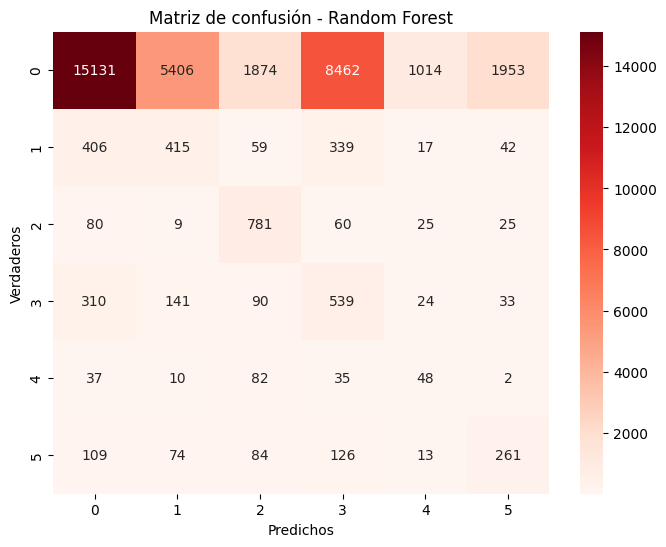

In [52]:
# Hacemos la predicción.
ypred_RF = cross_val_predict(model_RF_best, data_final, y, cv = cv6)

# Matriz de confusión.
cm = confusion_matrix(y, ypred_RF)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predichos")
plt.ylabel("Verdaderos")
plt.title("Matriz de confusión - Random Forest")
plt.show()

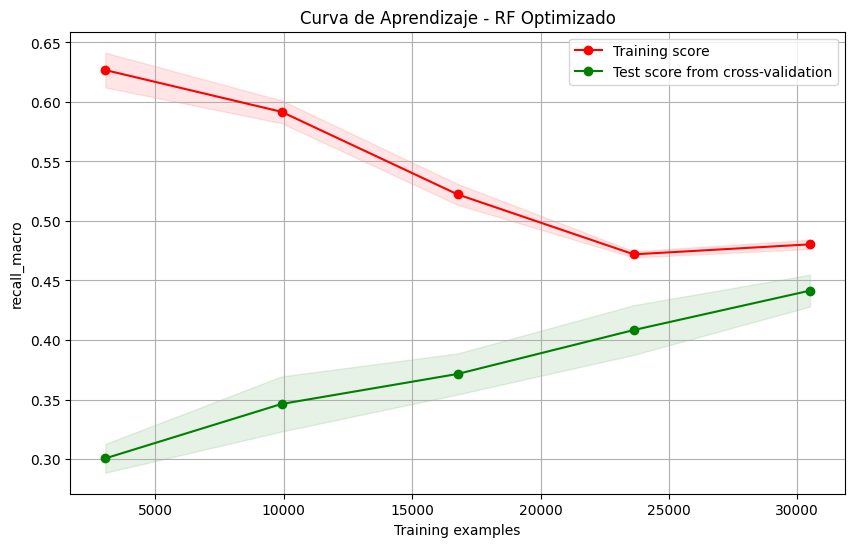

In [53]:
# Mostramos la curva de aprendizaje para el RF optimizado
plot_learning_curve(model_RF_best, 'Curva de Aprendizaje - RF Optimizado', data_final, y,  cv = cv6, scoring = 'recall_macro');
plt.show()

Aunque Random Forest es un modelo considerablemente más robusto que un árbol de decisión individual, presentó errores similares. Al igual que los modelos anteriores, mostró una marcada tendencia a clasificar las instancias como clase 0. No obstante, logró reducir ligeramente la cantidad de falsos positivos, lo que evidencia un mejor manejo del desbalance, aunque todavía insuficiente.

En la curva de aprendizaje se observa que, si bien el modelo comienza con alto bias y alta varianza, ambos valores disminuyen de manera significativa a medida que aumenta la cantidad de datos. De hecho, Random Forest termina siendo el modelo con menor varianza entre los tres evaluados, lo que indica una mayor estabilidad y capacidad de generalización. Por esta razón, fue seleccionado como el mejor modelo del análisis.

Hacia el final de la curva la pendiente parece comenzar a aplanarse, lo que podría sugerir que el modelo está alcanzando un punto donde ya no es capaz de aprender más. Sin embargo, esta interpretación sería apresurada; se requeriría un conjunto de datos aún mayor para verificar si realmente se ha llegado a ese límite o si el modelo seguiría mejorando con más información.

# Conclusión

En este trabajo se utilizaron tres modelos de machine learning junto con el conjunto de datos Meteorite Landings proporcionado por la NASA, con el objetivo de predecir el tipo de meteorito a partir de las características registradas en dicho catálogo.

Los datos presentaban un fuerte desbalance hacia un tipo de meteorito específico, lo que generó una gran cantidad de errores durante el modelado y afectó el desempeño de los algoritmos. Aun así, los modelos mostraron cierta capacidad de comprender y aprender patrones una vez alcanzado un volumen suficiente de datos, identificando que la característica más útil para distinguir entre las distintas clases de meteoritos es la masa de este mismo. A su vez, se logro identificar que el mejor modelo para predecir los tipos de meteoritos es el random forest debido a la baja varianza identificada en las curvas de aprendizaje

Para trabajos futuros, sería conveniente mejorar el conjunto de datos, tanto en términos de mayor cantidad de muestras como en una distribución más uniforme entre las clases. Además, se recomienda explorar modelos más robustos especialmente aquellos mejor adaptados a problemas multiclase, con el fin de obtener predicciones más estables y precisas.